<h1> Super Variant Spanning Tree </h1>

<h2> First Imports </h2>

In [1]:
from ocpa.objects.log.importer.csv import factory as ocel_import_factory
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
from ocpa.visualization.log.variants import factory as variants_visualization_factory

from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

D:\Program Files\Anaconda\lib\site-packages\pm4py\objects\petri\__init__.py:19: UserWarning: please use the pm4py.objects.petri_net package instead.
  warnings.warn('please use the pm4py.objects.petri_net package instead.')
D:\Program Files\Anaconda\lib\site-packages\pm4py\objects\petri\obj.py:19: UserWarning: pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.
  warnings.warn("pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.")
D:\Program Files\Anaconda\lib\site-packages\pm4py\objects\petri\exporter\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.exporter package instead.
  warnings.warn('please use the pm4py.objects.petri_net.exporter package instead.')
D:\Program Files\Anaconda\lib\site-packages\pm4py\objects\petri\importer\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.importer package instead.
  warnings.warn('please use the pm4py.objects.petri_net.i

In [2]:
filename = "EventLogs/OCEL_example.jsonocel"
ocel_running_example = ocel_import_factory.apply(filename)

In [3]:
filename = "EventLogs/order_process.jsonocel"
ocel_order_process = ocel_import_factory.apply(filename)

In [4]:
print("Number of process executions: "+str(len(ocel_order_process.process_executions)))
print("Number of variants: "+str(len(ocel_order_process.variants)))
print("The variants: " + str(ocel_order_process.variants))

Number of process executions: 48
Number of variants: 12
The variants: ['70c939f2919684da04e6e0d4a8ad9411', 'da02d9a87dda160e611b029024a88c8c', '1c94fef7fe6136b8b3740f5c9744d8a4', '7771fed26406c4a19803e9b9eed9d322', 'd13a7cd9b061ed69c4bff0cffc919bda', 'e1c3ee472f60eb3f3c2f87b5ec53247d', '291e6ea6123216e19e0f488a07ccca47', '812bc445b5881d7f6db133fc7f64a1ae', '2eea1b36f1c5d8871b0b2e8660625110', '4f4599e7e4922c1117376d72f8b9d4f3', 'e79ff5d9cb47d601e56d33b35129b4e1', 'cd8ffa58d076769d95c42bcea11abf23']


In [5]:
print("Number of process executions: "+str(len(ocel_running_example.process_executions)))
print("Number of variants: "+str(len(ocel_running_example.variants)))
print("The variants: " + str(ocel_running_example.variants))

Number of process executions: 3
Number of variants: 3
The variants: ['b97edd1d3d6e24b3f0f2352729d7518f', '7c4a54cda11c6846e5f82a936f01112e', '57a5df867c171e6c92a6e85257860b61']


<h2> Format Extraction </h2>

<h3> Input Variant Data Structures </h3>

In [6]:
class VariantLane:
    '''The data structure of one lane of a variant'''
    lane_id = 0
    object_type = ""
    lane_name = ""
    activities = []
    horizontal_indices = []
    
    def __init__(self, lane_id, object_type, name, activities, indices):
        self.lane_id = lane_id
        self.object_type = object_type
        self.lane_name = name
        self.activities = activities
        self.horizontal_indices = indices
    
    def __str__(self):
        result_string = f"ID: {self.lane_id}, Name: {self.lane_name}: ["
        for i in range(len(self.activities)):
            result_string += "(Pos: " + str(self.horizontal_indices[i]) + ", " + self.activities[i] + "),"       
        result_string = result_string[:-1]
        return result_string + "]"
    
    def has_type(self, input_type):
        return self.object_type == input_type

In [7]:
class InteractionPoint:
    '''The data structure of an Interaction Point'''
    activity_name = ""
    interaction_lanes = []
    interacting_types = {}
    index_in_lanes = 0
    
    def __init__(self, name, lanes, types, index):
        self.activity_name = name                                                                      
        self.interaction_lanes = lanes                                                                      
        self.interacting_types = types
        self.index_in_lanes = index
        
    def __str__(self):
        return f"Interaction Point: {self.activity_name} at Pos: {self.index_in_lanes}"

<h3> Lane Extraction </h3>

In [8]:
class ExtractedVariant:
    '''The data structure of a variant with extracted lanes'''
    object_types  = {}
    lanes = []
    interaction_points = {}
    
    def __init__(self, lanes, object_types, interaction_points):
        self.lanes = lanes
        self.object_types = object_types
        self.interaction_points = interaction_points
        
    def __str__(self):
        result_string = "Lanes: \n"
        for i in range(len(self.lanes)):
            result_string += str(self.lanes[i]) + "\n"
        result_string += "\nInvolved Objects: \n" + str(self.object_types) +"\n"
        result_string += "\nInteraction Points: \n"
        for i in range(len(self.interaction_points)):
            result_string += str(self.interaction_points[i]) + "\n"
        return result_string
    
    def get_lanes_of_type(self, object_type):
        return [lane for lane in self.lanes if lane.object_type == object_type]
    
    def get_lane(self, lane_id):
        return [lane for lane in self.lanes if lane.lane_id == lane_id][0]


In [9]:
def extract_lanes(variant):
    
    # Separate event elements and objects
    objects = variant[1]
    events = sorted(variant[0],key=lambda x: (x[1][0]))
    
    # Store the interaction points for preservation
    extracted_lanes = []
            
    # Create element for each lane in the variant, storing a lists of activities
    # and the object specification
    for i in range(len(objects)):
        lane = []
        positions = []
        for j in range(len(events)):
            if(i in events[j][1][1]):
                lane.append(events[j][0])
                positions.append(events[j][1][0][0])    
        
        extracted_lanes.append(VariantLane(i, objects[i][0], objects[i][1], lane, positions))
        
    extracted_interactions = []
    for i in range(len(events)):
        if (len(events[i][1][1]) > 1):
            types = []
            for j in range(len(events[i][1][1])):
                types.append(objects[events[i][1][1][j]][0])
            extracted_interactions.append(InteractionPoint((events[i][0]), events[i][1][1], set(types), events[i][1][0][0]))
    
    extracted_types = set([object[0] for object in objects.values()])
    extracted_variant = ExtractedVariant(extracted_lanes, extracted_types, extracted_interactions)
    return extracted_variant

<h3> Example Definition </h3>

In [10]:
variant_layouting = variants_visualization_factory.apply(ocel_order_process)
print(variant_layouting[ocel_order_process.variants[7]])

([['Fuel Car', [[4, 4], [0]]], ['Confirm Order', [[1, 1], [3, 2, 1]]], ['Payment Reminder', [[2, 2], [3]]], ['Pick Item', [[2, 2], [1]]], ['Start Route', [[5, 5], [0, 2, 1]]], ['End Route', [[6, 6], [0, 2, 1]]], ['Pick Item', [[2, 2], [2]]], ['Place Order', [[0, 0], [3, 2, 1]]], ['Pay Order', [[4, 4], [3]]], ['Load Cargo', [[3, 3], [0, 2, 1]]], ['Payment Reminder', [[3, 3], [3]]]], {0: ('delivery', 'delivery_1'), 1: ('item', 'item_1'), 2: ('item', 'item_2'), 3: ('order', 'order_1')})


In [11]:
variant_layouting = variants_visualization_factory.apply(ocel_running_example)
print(variant_layouting[ocel_running_example.variants[1]])

([['I', [[3, 3], [0]]], ['D', [[3, 3], [3]]], ['A', [[0, 0], [3]]], ['O', [[2, 2], [2, 0, 3, 1]]], ['E', [[3, 3], [2]]], ['I', [[3, 3], [1]]], ['B', [[1, 1], [3]]], ['F', [[4, 4], [2, 0, 1]]]], {0: ('items', 'items_1'), 1: ('items', 'items_2'), 2: ('items', 'items_3'), 3: ('orders', 'orders_1')})


In [12]:
variant_layouting = variants_visualization_factory.apply(ocel_order_process)
variant = extract_lanes(variant_layouting[ocel_order_process.variants[8]])
#variant = extract_lanes(variant_layouting[ocel_running_example.variants[1]])
print(variant)

Lanes: 
ID: 0, Name: delivery_1: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 1, Name: delivery_2: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 2, Name: delivery_3: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 3, Name: delivery_4: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 4, Name: delivery_5: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 5, Name: delivery_6: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 6, Name: delivery_7: [(Pos: 0, Fuel Car),(Pos: 5, Load Cargo),(Pos: 6, Start Route),(Pos: 7, End Route)]
ID: 7, Name: delivery_8: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 8, Name: delivery_9: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 9, Name

<h2> Construct Variant Summarization </h2>

<h3> Super Variant Objects </h3>

<h3> Output Variant Data Structures </h3>

In [13]:

class SummarizedVariant:
    '''The data structure of a summarized object-centric variant'''
    object_types = {}
    lanes = []
    interaction_points = []
    
    def __init__(self, lanes, object_types, interaction_points):
        self.lanes = lanes
        self.object_types = object_types
        self.interaction_points = interaction_points
    
    def __str__(self):
        result_string = "Lanes: \n"
        for i in range(len(self.lanes)):
            result_string += str(self.lanes[i]) + "\n"
        result_string += "\nInvolved Objects: \n" + str(self.object_types) +"\n"
        result_string += "\nInteraction Points: \n"
        for i in range(len(self.interaction_points)):
            result_string += str(self.interaction_points[i]) + "\n"
        return result_string
    
    
class SummarizedLane:
    '''The data structure of a summarized object-centric variant'''
    lane_id = ()
    object_type = ""
    lane_name = ""
    elements = []
    horizontal_indices = []
    
    def __init__(self, lane_id, name, object_type, elements, indices):
        self.lane_id = lane_id
        self.object_type = object_type
        self.lane_name = name
        self.elements = elements
        self.horizontal_indices = indices
    
    def __str__(self):
        result_string = f"ID: {self.lane_id}, Name: {self.lane_name}: ["
        for i in range(len(self.elements)):
            result_string += "(Pos: " + str(self.horizontal_indices[i]) + ", " + str(self.elements[i]) + "),"       
        result_string = result_string[:-1]
        return result_string + "]"
    
    def update_indices(self, start_index, offset):
        for i in range(start_index, len(self.horizontal_indices)):
            self.horizontal_indices[i] += offset
            
class SummarizedConstruct:
    '''The data structure the elements of a summarized variant'''

class CommonConstruct(SummarizedConstruct):
    '''The data structure of common activities in a summarized variant'''
    activity = ""
    
    def __init__(self, activity):
        self.activity = activity
        
    def __str__(self):
        return f"{self.activity}"

    
class OptionalConstruct(SummarizedConstruct):
    '''The data structure of an optional activity in a summarized variant'''
    option = ""
    
    def __init__(self, option):
        self.option = option
    
    def __str__(self):
        return f"Optional {self.option})"

    
class ChoiceConstruct(SummarizedConstruct):
    '''The data structure of a choice of activities in a summarized variant'''
    choices = []
    
    def __init__(self, choices):
        self.choices = choices
        
    def __str__(self):
        return f"Choices {self.choices}"

In [14]:
def convert_to_summarized_format(lane):
    '''
    Converts a single line that needs no summarization to the desired format
    :param lane: The single flattened lane of one involved object
    :type lane: Lane
    :return: single lane converted into a summarized format
    :rtype:SummarizedLane
    '''
    elements = []
    indices = []
    for i in range(len(lane.activities)):
        elements.append(CommonConstruct(lane.activities[i]))
        indices.append(lane.horizontal_indices[i])
    
    result = SummarizedLane(tuple()+(lane.lane_id,), lane.object_type ,lane.object_type, elements, indices)
    return result
    

<h3> Common Activities Function </h3>

In [15]:
def max_order_preserving_common_activities(lanes):
    '''
    Extracts the longest sequence od activities found in all lanes, preserving their order
    :param lanes: Multiple sequences of activities
    :type lanes: list of VariantLane
    :return: the longest order preserving common activity sequence and their indices in the variant
    :rtype: dict
    '''
    # Initialization, copy elements
    activity_sets = []
    l = [lane.activities for lane in lanes]
    base_lane = l[0]
    base_indices = lanes[0].horizontal_indices
    
    # Retrieves all common sublists that ensure the precise order
    for i in range(len(base_lane)):
        
        # Keeping track of the original indices and the remaining sublists
        comparison = [] 
        indices = []
        for lane in range(1,len(l)):
            comparison.append(lanes[lane].activities)
            indices.append(lanes[lane].horizontal_indices)
            
        set = dict()
        
        # For each activity in base lane as starting point find the list of activities
        # that appear in all other lanes
        for j in range(i,len(base_lane)):
            if (all(base_lane[j] in lane for lane in comparison[0:])):

                #Create result tuple
                indices_of_lane = ()
                indices_of_lane = indices_of_lane + (base_indices[j],)
                
                # Add the corresponding index for each other variant and adjust the lists
                for k in range(len(comparison)):
                    indices_of_lane = indices_of_lane + (indices[k][comparison[k].index(base_lane[j])],)
                    indices[k] = indices[k][comparison[k].index(base_lane[j])+1:]
                    comparison[k] = comparison[k][comparison[k].index(base_lane[j])+1:]
                
                set[base_lane[j]] = indices_of_lane
        activity_sets.append(set)
        
    # Return the maximal list of activities for optimality
    return max(activity_sets, key=len)

<h3> Partition Testing </h3>

In [16]:
import itertools
from itertools import permutations

def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller
        
def pad_or_truncate(some_list, target_len):
    return some_list[:target_len] + [[]]*(target_len - len(some_list))

l1 = ["A","B","C"]
l2 = ["D","E"]
for number1, partition1 in enumerate(partition(l1), 1):
    for number2, partition2 in enumerate(partition(l2), 1):
        max_length = max(len(partition1), len(partition2))
        partition1 = pad_or_truncate(partition1,max_length)
        partition2 = pad_or_truncate(partition2,max_length)
        print(number1, sorted(partition1))
        print(number2, sorted(partition2))
        unique_combinations = []
        permut = itertools.permutations(partition1, len(partition2))
        for comb in permut:
            zipped = zip(comb, partition2)
            unique_combinations.append(list(zipped))
        print(unique_combinations)
        print("\n")

1 [['A', 'B', 'C']]
1 [['D', 'E']]
[[(['A', 'B', 'C'], ['D', 'E'])]]


1 [[], ['A', 'B', 'C']]
2 [['D'], ['E']]
[[(['A', 'B', 'C'], ['D']), ([], ['E'])], [([], ['D']), (['A', 'B', 'C'], ['E'])]]


2 [['A'], ['B', 'C']]
1 [[], ['D', 'E']]
[[(['A'], ['D', 'E']), (['B', 'C'], [])], [(['B', 'C'], ['D', 'E']), (['A'], [])]]


2 [['A'], ['B', 'C']]
2 [['D'], ['E']]
[[(['A'], ['D']), (['B', 'C'], ['E'])], [(['B', 'C'], ['D']), (['A'], ['E'])]]


3 [['A', 'B'], ['C']]
1 [[], ['D', 'E']]
[[(['A', 'B'], ['D', 'E']), (['C'], [])], [(['C'], ['D', 'E']), (['A', 'B'], [])]]


3 [['A', 'B'], ['C']]
2 [['D'], ['E']]
[[(['A', 'B'], ['D']), (['C'], ['E'])], [(['C'], ['D']), (['A', 'B'], ['E'])]]


4 [['A', 'C'], ['B']]
1 [[], ['D', 'E']]
[[(['B'], ['D', 'E']), (['A', 'C'], [])], [(['A', 'C'], ['D', 'E']), (['B'], [])]]


4 [['A', 'C'], ['B']]
2 [['D'], ['E']]
[[(['B'], ['D']), (['A', 'C'], ['E'])], [(['A', 'C'], ['D']), (['B'], ['E'])]]


5 [['A'], ['B'], ['C']]
1 [[], [], ['D', 'E']]
[[(['A'], ['D', 'E

<h2> Branching Approach </h3>

<h3> Pattern Application </h3>
TODO: The Optional Pattern is actually just a side-case of the Exclusive Choice Pattern. A choice can be optional as well, if there exists one choice that is empty. Must be extended. Also, variations in the alignment of choices exist that need branching.

In [17]:
def is_interaction_point(interactions, activity_name, positions):
    '''
    Determines whether one of the merged original activities of a summarized activity is an interaction point
    :param interactions: The interaction points of the variant
    :type interaction: List of type InteractionPoint
    :param activity_name: The name of the activity that is checked
    :type activity_name: String
    :param positions: The original indices of the merged activities
    :type positions: Tuple
    :return: Whether the activity at any of the given positions is listed as an interaction point
    :rtype: Boolean
    '''
    for interaction in interactions:
        if interaction.activity_name == activity_name and interaction.index_in_lanes in positions:
            return True  
    return False

In [18]:
def check_optional_pattern(activities):
    '''
    Checks whether only one of the given activities subsequences is non-empty, thus allowing 
    to apply the Optional Pattern
    :param activities: subsequences of activities of multiple lanes between common activities
    :type activities: list
    :return: Whether or not the Optional Pattern can be applied
    :rtype: Boolean
    '''
    non_empty_sequences = [activity_list[0] for activity_list in activities if activity_list[0]]
    non_empty_sequences = [list(sequence) for sequence in set(tuple(sequence) for sequence in non_empty_sequences)]
    return len(non_empty_sequences) == 1

In [396]:
def apply_patterns(activities, interactions):
    '''
    Determines an applicable pattern (Optional Pattern or Exclusive Choice Pattern) for a set of activity sequences 
    and their current indices
    :param activities: A list of activity sequences and their indices
    :type activities: List
    :param interactions: The interaction points of the variant of the lanes
    :type interactions: List of type InteractionPoint
    :return: The application of a pattern to summarize the sequences, the number of elements of the summarization, 
             the mapping from orginal interaction points to their new indices in the summatrized sequence
    :rtype: List of type SummarizedConstruct, Int, Dictionary
    '''
    if sum([len(activity_list[0]) for activity_list in activities]) == 0:
        return [], 0, {}
    
    elements = []
    length = 0
    new_interaction_points_mapping = {}
    
    if(check_optional_pattern(activities)):
        
        optional_activities = [activity_list for activity_list in activities if activity_list[0]]
        
        for i in range(len(optional_activities[0][0])):
            
            # Output printing
            print("\n")
            print("Adding the optional activity: ")
            print(optional_activities[0][0][i])
            
            # Storing the new positions of the interaction points
            indices = tuple()
            for j in range(len(optional_activities)):
                indices += (optional_activities[j][1][i],)

                
            is_interacting_activity = is_interaction_point(interactions, optional_activities[0][i],indices)        
            print("This is an interaction point: " + str(is_interacting_activity))
            if (is_interacting_activity):
                for index in (indices):
                    new_interaction_points_mapping[index,optional_activities[0][0][i]] = length
            
            # Adding Construct
            elements.append(OptionalConstruct(optional_activities[0][0][i]))
            length += 1
            
        return elements, length, new_interaction_points_mapping
    
    else:
        
        choice_activities = [activity_list for activity_list in activities]
        longest_option = max([choice[0] for choice in choice_activities], key=len)
        unique_choice_sequences = [list(sequence) for sequence in set(tuple(sequence) for sequence in [option[0] for option in choice_activities])]
        
        # Add the corresponding choices
        for i in range(len(longest_option)):
            
            # Determine the activity at index i for each choice
            choice = []
            for j in range(len(unique_choice_sequences)):
                if (i < len(unique_choice_sequences[j])):
                    choice.append(unique_choice_sequences[j][i])
                else:
                    choice.append("")
            
            # Storing the new positions of the interaction points
            contains_interaction_point = False
            for elem in choice_activities:
                if(len(elem[1])>i):
                    index = elem[1][i]
                    is_interacting_activity = is_interaction_point(interactions, elem[0][i],[index])    
                    contains_interaction_point = (contains_interaction_point or is_interacting_activity)
                    if (is_interacting_activity):
                        new_interaction_points_mapping[index, elem[0][i]] = length
                        
            if(len(set(choice)) == 2 and "" in set(choice)):
                print("This option containts an interaction point: " + str(is_interacting_activity))
            
                # Output printing
                print("\n")
                print("Adding the optional activity: ")
                print([c for c in choice if c != ""][0])
            
            # Adding Construct
                elements.append(OptionalConstruct([c for c in choice if c != ""][0]))
                length += 1
            else:
                print("This choice containts an interaction point: " + str(is_interacting_activity))
            
                # Output printing
                print("\n")
                print("Adding the choice between the following activity: ")
                print(choice)
            
                # Adding Construct
                elements.append(ChoiceConstruct(choice))
                length += 1
            
        return elements, length, new_interaction_points_mapping

<h3> Summarization Functions </h3>

In [397]:
def summarize_lanes(lanes, interactions):
    '''
    Yields a generic summarizations of lanes of the same object type
    :param lanes: The lanes of the same object type that need summarization
    :type lanes: List of Variant Lanes
    :param interactions: The interaction points of the variant of the lanes
    :type interactions: List of Interaction Points
    :return: The summarization of the given lanes
    :rtype: SummarizedLane
    '''
    common_activities = max_order_preserving_common_activities(lanes)

    # Initializing the values for the summarized lanes object
    elements = []
    horizontal_indices = []
    object_type = lanes[0].object_type
    lane_name = lanes[0].object_type + " i"
    lane_id = tuple([lane.lane_id for lane in lanes])
    
    new_interaction_points_mapping = {}
    current_horizontal_index = 0
    
    # Add current indices for all lanes into a list
    positions = []
    for i in range(len(lanes)):
        first_index = list(common_activities.values())[0][i]
        positions.append((0,first_index))
        
    for i in range(len(common_activities)):
        
        # Determine all interval subprocesses and summarize them
        interval_subprocesses = []
        for j in range(len(lanes)):
            start_index = positions[j][0]
            end_index = lanes[j].horizontal_indices.index(positions[j][1])
            interval_subprocesses.append((lanes[j].activities[start_index:end_index],lanes[j].horizontal_indices[start_index:end_index]))
        
        # Add summarized subprocess to elements
        print("\n")
        print("Applying a pattern to the elements: ")
        print("\n")
        print(interval_subprocesses)
        interval_elements, interval_length, intermediate_new_interaction_points = apply_patterns(interval_subprocesses, interactions)
        elements.extend(interval_elements)
        horizontal_indices.extend(list(range(current_horizontal_index, current_horizontal_index + interval_length)))
        for key in list(intermediate_new_interaction_points.keys()):
            new_interaction_points_mapping[key] = intermediate_new_interaction_points[key] + current_horizontal_index
            print("We added the mapping: " + str(key) + " to " + str(intermediate_new_interaction_points[key] + current_horizontal_index))
        current_horizontal_index += interval_length
                     
        # Add the common activity to the elements of the summarized lane
        print("\n")
        print("Adding the common activity: ")
        print(list(common_activities.keys())[i])
        is_interacting_activity = is_interaction_point(interactions, list(common_activities.keys())[i],list(common_activities.values())[i])        
        print("This is an interaction point: " + str(is_interacting_activity))
        if (is_interacting_activity):
            for index in (set(list(common_activities.values())[i])):
                new_interaction_points_mapping[index,list(common_activities.keys())[i]] = current_horizontal_index
                print("We added the mapping: " + str(tuple([index,list(common_activities.keys())[i]])) + " to " + str(current_horizontal_index))
        
        elements.append(CommonConstruct(list(common_activities.keys())[i]))
        horizontal_indices.append(current_horizontal_index)
        current_horizontal_index += 1
            
        # Update indices for the next iteration
        new_positions = []
        for j in range(len(lanes)):
            if(i+1 < len(common_activities.values())):
                next_index = list(common_activities.values())[i+1][j]
            else:
                next_index = lanes[j].horizontal_indices[-1]
            new_positions.append((lanes[j].horizontal_indices.index(positions[j][1])+1,next_index))
        positions = new_positions
    
    # Check all activities after the last common activity
    interval_subprocesses = []
    for j in range(len(lanes)):
        start_index = positions[j][0]
        interval_subprocesses.append((lanes[j].activities[start_index:],lanes[j].horizontal_indices[start_index:]))
    
    # Add summarized subprocess to elements
    interval_elements, interval_length, intermediate_new_interaction_points = apply_patterns(interval_subprocesses, interactions)
    elements.extend(interval_elements)
    horizontal_indices.extend(list(range(current_horizontal_index, current_horizontal_index + interval_length)))
    for key in list(intermediate_new_interaction_points.keys()):
            new_interaction_points_mapping[key] = intermediate_new_interaction_points[key] + current_horizontal_index
            print("We added the mapping: " + str(key) + " to " + str(intermediate_new_interaction_points[key] + current_horizontal_index))
    current_horizontal_index += interval_length
        
    return SummarizedLane(lane_id, lane_name, object_type, elements, horizontal_indices), new_interaction_points_mapping
                                          
            
        

In [398]:
def merge_interaction_mappings(mappings):
    '''
    Pre-processes the mappings from the summarization for easy handling
    :param mappings: The mappings of original interaction points to new indices in the summarized lanes
    :type mappings: Dictionary
    :return: Each interaction point of the summarized lanes and their current positions in the involved lanes
    :rtype: Dictionary
    '''

    merged_mappings = {}
    # merge the individual dictionaries for all lanes
    for i in range(len(mappings)):
        mapping = mappings[i][1]
        for key in mapping.keys():
            value = {}
            for k in range(len(mappings)):
                if(key in list(mappings[k][1].keys())):
                    value[mappings[k][0]] = mappings[k][1][key]
            merged_mappings[key] = value
            
    new_interactions = {}
    # merge all mappings that represent the same new interaction point
    for key in merged_mappings.keys():
        value = merged_mappings[key]
        merging_candidates = [k for k in list(merged_mappings.keys()) if merged_mappings[k] == value]
        
        if not(any(k in merging_candidates for k in list(new_interactions.keys()))):
            new_interactions[key] = value
    
    # Remove all interaction points, that no longer are interaction points
    result = {}
    for key in new_interactions.keys():
        if (len(list(new_interactions[key].keys())) > 1):
            result[key] = new_interactions[key]
            
    return result            
            

In [399]:
def re_align_lanes(lanes, mappings):
    '''
    Given the summarized lanes and the mappings from original interaction points to new indices, this method aligns the lane, such
    that interaction points between multiple lanes have the same horizontal index
    :param lanes: The summarized lanes
    :type lanes: List of type SummarizedLane
    :param mappings: The mappings of original interaction points to new indices in the summarized lanes for each lane
    :type mappings: Dictionary
    :return: The lanes with updated horizontal indices and a list of the corresponding interaction points
    :rtype: List of type SummarizedLane, List of type InteractionPoint
    '''
    # Initialize variables and return values
    import copy
    mappings = merge_interaction_mappings(mappings)
    aligned_lanes = copy.deepcopy(lanes)
    updated_mappings = copy.deepcopy(mappings)
    updated_interaction_points = []
    
    # Align the lanes such that the interaction points have the same horizontal index
    for i in range(len(mappings.keys())):
        earliest_interaction_point = min(updated_mappings.items(), key=lambda x: list(x[1].values()))
        print("We have an interaction at the following points the the interacting lanes: " + str(earliest_interaction_point[1]))
        name = earliest_interaction_point[0][1]
        lanes = [lane.lane_id for lane in aligned_lanes if lane.object_type in list(earliest_interaction_point[1].keys())]
        types = list(earliest_interaction_point[1].keys())
        
        if(len(set(list(earliest_interaction_point[1].values()))) == 1):
            print("No alignment required.")
            position = list(earliest_interaction_point[1].values())[0]
            
        else: 
            target_position = max(set(list(earliest_interaction_point[1].values())))
            position = target_position
            involved_lanes = [lane for lane in aligned_lanes if lane.object_type in list(earliest_interaction_point[1].keys())]
            for lane in involved_lanes:
                
                # Shift indices by the offset
                current_position = updated_mappings[earliest_interaction_point[0]][lane.object_type]
                offset = target_position - current_position
                print("We have shifted lane " + lane.lane_name + " by " + str(offset) + " starting from activity " + str(lane.elements[lane.horizontal_indices.index(current_position)]) + ".")
                lane.update_indices(lane.horizontal_indices.index(current_position),offset)
                
                
                # Update all values in the dictionary accordingly
                for key in updated_mappings.keys():
                    if(lane.object_type in updated_mappings[key].keys() and updated_mappings[key][lane.object_type]>=current_position):
                        updated_mappings[key][lane.object_type] += offset
                
        del updated_mappings[earliest_interaction_point[0]]
        updated_interaction_points.append(InteractionPoint(name, lanes, types, position))
        
    return aligned_lanes, updated_interaction_points

                            

                        

In [400]:
def summarize_variant(variant):
    '''
    
    '''
    # Initialize result variables
    result_lanes = []
    updated_interaction_points = []
    object_types = variant.object_types
    remaining_lanes = [lane.lane_id for lane in variant.lanes]
    
    interaction_points_mapping = []
    
    # Inilialize keep track of the sets of lanes that require summarization
    initial_candidate_set = [lane.lane_id for lane in variant.get_lanes_of_type(variant.lanes[0].object_type)]
    to_be_summarized = [initial_candidate_set]
    i = 0 
    
    while to_be_summarized:
        print('─' * 40)
        print("Iteration: " + str(i))
        summarization_candidates = to_be_summarized.pop()
        print("Summarizing lanes of type " + variant.get_lane(summarization_candidates[0]).object_type + ":")  
        print(summarization_candidates)
        print("\n")
        
        # Keep track of the remaining lanes that need to be summarized
        remaining_lanes = [lane for lane in remaining_lanes if lane not in summarization_candidates]
            
        # Determine all involved interaction_points of the summarization
        involved_interaction_points = []
        involved_lanes = []
        for interaction_point in variant.interaction_points:
            if any(elem in summarization_candidates for elem in interaction_point.interaction_lanes):
                involved_interaction_points.append(interaction_point)
                involved_lanes.extend(interaction_point.interaction_lanes)
        
        involved_lanes = set(involved_lanes)
        
        lanes = [variant.get_lane(candidate) for candidate in summarization_candidates]
        summarized_lane, new_mappings = summarize_lanes(lanes,involved_interaction_points)
        interaction_points_mapping.append((variant.get_lane(summarization_candidates[0]).object_type,new_mappings))
        result_lanes.append(summarized_lane)
        print("\n")
        print("Intermediate Result:")
        print("\n")
        print(result_lanes[-1])
        print("\n")
        
        # Determine the next summarization candidates by extracting all still not summarized involved lanes
        external_involved_lanes = [elem for elem in remaining_lanes if elem in involved_lanes]
        for type in object_types:
            next_candidates = [lane_id for lane_id in external_involved_lanes if variant.get_lane(lane_id).object_type == type]
            
            # Cluster the candidates by type and add to list
            if len(next_candidates)>0 :
                print("Adding involved lanes of type " + str(type) + " to the candidate list of the next iterations.")
                to_be_summarized.append(next_candidates)
                print("These are: \n")
                print(to_be_summarized[-1])
                print("\n")
            
        i += 1
    print('─' * 40)
    print("Aligning the lanes:")
    print("\n")
    result_lanes, result_interaction_points = re_align_lanes(result_lanes, interaction_points_mapping)
    return SummarizedVariant(result_lanes,object_types,result_interaction_points)
        


<h2> Example Display </h2>

In [401]:
variant_layouting = variants_visualization_factory.apply(ocel_order_process)
variant_1 = extract_lanes(variant_layouting[ocel_order_process.variants[8]])
print(variant_1)

Lanes: 
ID: 0, Name: delivery_1: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 1, Name: delivery_2: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 2, Name: delivery_3: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 3, Name: delivery_4: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 4, Name: delivery_5: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 5, Name: delivery_6: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 6, Name: delivery_7: [(Pos: 0, Fuel Car),(Pos: 5, Load Cargo),(Pos: 6, Start Route),(Pos: 7, End Route)]
ID: 7, Name: delivery_8: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 8, Name: delivery_9: [(Pos: 3, Load Cargo),(Pos: 4, Fuel Car),(Pos: 5, Start Route),(Pos: 6, End Route)]
ID: 9, Name

In [402]:
generic_summarized_variant_1 = summarize_variant(variant_1)

────────────────────────────────────────
Iteration: 0
Summarizing lanes of type delivery:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]




Applying a pattern to the elements: 


[([], []), ([], []), ([], []), ([], []), ([], []), ([], []), (['Fuel Car'], [0]), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], []), (['Fuel Car'], [0]), ([]

In [403]:
print(generic_summarized_variant_1)

Lanes: 
ID: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149), Name: delivery i: [(Pos: 0, Optional Fuel Car)),(Pos: 5, Load Cargo),(Pos: 6, Optional Fuel Car)),(Pos: 7, Start Route),(Pos: 8, End Route)]
ID: (150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 

In [404]:
variant_layouting = variants_visualization_factory.apply(ocel_running_example)
variant_2 = extract_lanes(variant_layouting[ocel_running_example.variants[1]])
print(variant_2)

Lanes: 
ID: 0, Name: items_1: [(Pos: 2, O),(Pos: 3, I),(Pos: 4, F)]
ID: 1, Name: items_2: [(Pos: 2, O),(Pos: 3, I),(Pos: 4, F)]
ID: 2, Name: items_3: [(Pos: 2, O),(Pos: 3, E),(Pos: 4, F)]
ID: 3, Name: orders_1: [(Pos: 0, A),(Pos: 1, B),(Pos: 2, O),(Pos: 3, D)]

Involved Objects: 
{'orders', 'items'}

Interaction Points: 
Interaction Point: O at Pos: 2
Interaction Point: F at Pos: 4



In [405]:
generic_summarized_variant_2 = summarize_variant(variant_2)

────────────────────────────────────────
Iteration: 0
Summarizing lanes of type items:
[0, 1, 2]




Applying a pattern to the elements: 


[([], []), ([], []), ([], [])]


Adding the common activity: 
O
This is an interaction point: True
We added the mapping: (2, 'O') to 0


Applying a pattern to the elements: 


[(['I'], [3]), (['I'], [3]), (['E'], [3])]
This choice containts an interaction point: False


Adding the choice between the following activity: 
['I', 'E']


Adding the common activity: 
F
This is an interaction point: True
We added the mapping: (4, 'F') to 2


Intermediate Result:


ID: (0, 1, 2), Name: items i: [(Pos: 0, O),(Pos: 1, Choices ['I', 'E']),(Pos: 2, F)]


Adding involved lanes of type orders to the candidate list of the next iterations.
These are: 

[3]


────────────────────────────────────────
Iteration: 1
Summarizing lanes of type orders:
[3]




Applying a pattern to the elements: 


[([], [])]


Adding the common activity: 
A
This is an interaction point: 

In [406]:
print(generic_summarized_variant_2)

Lanes: 
ID: (0, 1, 2), Name: items i: [(Pos: 2, O),(Pos: 3, Choices ['I', 'E']),(Pos: 4, F)]
ID: (3,), Name: orders i: [(Pos: 0, A),(Pos: 1, B),(Pos: 2, O),(Pos: 3, D)]

Involved Objects: 
{'orders', 'items'}

Interaction Points: 
Interaction Point: O at Pos: 2



In [407]:
variant_layouting = variants_visualization_factory.apply(ocel_running_example)
variant_3 = extract_lanes(variant_layouting[ocel_running_example.variants[0]])
print(variant_3)

Lanes: 
ID: 0, Name: items_1: [(Pos: 2, C),(Pos: 3, H),(Pos: 4, E),(Pos: 5, F)]
ID: 1, Name: items_2: [(Pos: 2, C),(Pos: 4, E),(Pos: 5, F),(Pos: 6, G)]
ID: 2, Name: orders_1: [(Pos: 0, A),(Pos: 1, B),(Pos: 2, C),(Pos: 3, D)]

Involved Objects: 
{'orders', 'items'}

Interaction Points: 
Interaction Point: C at Pos: 2
Interaction Point: E at Pos: 4
Interaction Point: F at Pos: 5



In [408]:
generic_summarized_variant_3 = summarize_variant(variant_3)

────────────────────────────────────────
Iteration: 0
Summarizing lanes of type items:
[0, 1]




Applying a pattern to the elements: 


[([], []), ([], [])]


Adding the common activity: 
C
This is an interaction point: True
We added the mapping: (2, 'C') to 0


Applying a pattern to the elements: 


[(['H'], [3]), ([], [])]


Adding the optional activity: 
H
This is an interaction point: False


Adding the common activity: 
E
This is an interaction point: True
We added the mapping: (4, 'E') to 2


Applying a pattern to the elements: 


[([], []), ([], [])]


Adding the common activity: 
F
This is an interaction point: True
We added the mapping: (5, 'F') to 3


Adding the optional activity: 
G
This is an interaction point: False


Intermediate Result:


ID: (0, 1), Name: items i: [(Pos: 0, C),(Pos: 1, Optional H)),(Pos: 2, E),(Pos: 3, F),(Pos: 4, Optional G))]


Adding involved lanes of type orders to the candidate list of the next iterations.
These are: 

[2]


──────────────────────

In [409]:
print(generic_summarized_variant_3)

Lanes: 
ID: (0, 1), Name: items i: [(Pos: 2, C),(Pos: 3, Optional H)),(Pos: 4, E),(Pos: 5, F),(Pos: 6, Optional G))]
ID: (2,), Name: orders i: [(Pos: 0, A),(Pos: 1, B),(Pos: 2, C),(Pos: 3, D)]

Involved Objects: 
{'orders', 'items'}

Interaction Points: 
Interaction Point: C at Pos: 2



In [410]:
def summarized_variant_layouting(summarized_variant):
    items = {}
    
    # Create dictionary of objects
    for type in summarized_variant.object_types:
        object_lanes = [lane for lane in summarized_variant.lanes if lane.object_type == type]
        for lane in object_lanes:
            items[lane.lane_id] = (type, lane.lane_name)
    
    # Create list of activities and their indices
    activities = []
    for lane in summarized_variant.lanes:
        for i in range(len(lane.elements)):
            interactions = [lane.lane_id]
            for interactionPoint in summarized_variant.interaction_points:
                if(lane.lane_id in interactionPoint.interaction_lanes and lane.horizontal_indices[i] == interactionPoint.index_in_lanes):
                    interactions.extend(interactionPoint.interaction_lanes)

            activities.append([lane.elements[i],[[lane.horizontal_indices[i],lane.horizontal_indices[i]],list(set(interactions))]])
    
    # Remove duplicate activities that are interaction points
    unique_activities = []
    for activity in activities:
        identical_activities = [u_activity for u_activity in unique_activities if activity[1][0][0] == u_activity[1][0][0] and activity[1][1] == u_activity[1][1]]
        if (len(identical_activities) < 1):
            unique_activities.append(activity)
    
    return[unique_activities,items]

In [411]:
print(summarized_variant_layouting(generic_summarized_variant_1))

[[[<__main__.OptionalConstruct object at 0x000002255DDC03D0>, [[0, 0], [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149)]]], [<__main__.CommonConstruct object at 0x000002255DDC0EE0>, [[5, 5], [(150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,

In [412]:
print(summarized_variant_layouting(generic_summarized_variant_2))

[[[<__main__.CommonConstruct object at 0x000002255D6BA0A0>, [[2, 2], [(0, 1, 2), (3,)]]], [<__main__.ChoiceConstruct object at 0x000002255C427730>, [[3, 3], [(0, 1, 2)]]], [<__main__.CommonConstruct object at 0x000002255DFDF160>, [[4, 4], [(0, 1, 2)]]], [<__main__.CommonConstruct object at 0x000002255DFDF250>, [[0, 0], [(3,)]]], [<__main__.CommonConstruct object at 0x000002255DFDF2E0>, [[1, 1], [(3,)]]], [<__main__.CommonConstruct object at 0x000002255DFDF400>, [[3, 3], [(3,)]]]], {(3,): ('orders', 'orders i'), (0, 1, 2): ('items', 'items i')}]


<h2> Intermediate Visualization </h2>

In [413]:
DEFAULT_CHEVRON_LENGTH = 7.
DEFAULT_CHEVRON_HEIGHT = 4.

def chevron_at_position(vertical_index, horizontal_index, length, height):
    
    from matplotlib.path import Path
    verts = [
       (horizontal_index, vertical_index),  # Left bottom coner
       (horizontal_index + DEFAULT_CHEVRON_LENGTH * length, vertical_index),  # Right bottom corner
       (horizontal_index + DEFAULT_CHEVRON_LENGTH * length + 1.2, vertical_index + height/2), # Outer tip of chevron
       (horizontal_index + DEFAULT_CHEVRON_LENGTH * length, vertical_index + height),  # Right top coner
       (horizontal_index, vertical_index + height),  # Left bottom coner
       (horizontal_index + 1.2, vertical_index + height/2), # Inner top of chevron
       (horizontal_index, vertical_index),  # Left bottom coner
    ]

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]

    return Path(verts, codes)

def add_chevron_divider(vertical_index, horizontal_index, length):
    
    from matplotlib.path import Path
    verts = [
       (horizontal_index, vertical_index),  # Left starting point
       (horizontal_index + DEFAULT_CHEVRON_LENGTH * length, vertical_index),  # Right ending point
    ]

    codes = [
        Path.MOVETO,
        Path.LINETO,
    ]
    return Path(verts, codes)
    

In [414]:
def summarized_activity_chevron(ax, activity, lane_property, color):
    
    import math
    from matplotlib.path import Path
    import matplotlib.patches as patches
    line_style = '-'
    label = ""
    
    # Define label and line type for each type of construct
    if (type(activity[0]) == OptionalConstruct):
        line_style = '--'
        label = activity[0].option
        ax.text(activity[1][0][0]*DEFAULT_CHEVRON_LENGTH+2.5, lane_property[1]+(1/2)*lane_property[0] - 0.4, label)
        
    elif (type(activity[0]) == CommonConstruct):
        label = activity[0].activity
        ax.text(activity[1][0][0]*DEFAULT_CHEVRON_LENGTH+2.5, lane_property[1]+(1/2)*lane_property[0] - 0.4, label)
        
    else: 
        # Write each choice and seperate by a line
        offset = lane_property[0]/len(activity[0].choices)
        for i in range(len(activity[0].choices)):
            ax.text(activity[1][0][0]*DEFAULT_CHEVRON_LENGTH+2.5, 1.5+lane_property[1]+offset*i, activity[0].choices[i])
            above_halfways = lane_property[1] + lane_property[1]+offset*i >= lane_property[1] + 0.5*lane_property[0]
            horizontal_shift = 0.1
            if(above_halfways):
                ax.add_patch(patches.PathPatch(add_chevron_divider(lane_property[1] + lane_property[1]+offset*i, activity[1][0][0]*DEFAULT_CHEVRON_LENGTH+1.2-horizontal_shift*i,1),lw=2,zorder=10))
            else:
                ax.add_patch(patches.PathPatch(add_chevron_divider(lane_property[1] + lane_property[1]+offset*i, activity[1][0][0]*DEFAULT_CHEVRON_LENGTH+horizontal_shift*i,1),lw=2,zorder=10))
    
    ax.add_patch(patches.PathPatch(chevron_at_position(lane_property[1], activity[1][0][0]*DEFAULT_CHEVRON_LENGTH, 1, lane_property[0]), facecolor=color, lw=2, ls = line_style))
    return ax  

In [415]:
def visualize_summarized_variant(variant):
    import matplotlib.pyplot as plt
    from matplotlib.path import Path
    import matplotlib.patches as patches
     
    # Defining the colors for each lane
    colors = ['peachpuff','palegoldenrod', 'thistle', 'plum', 'moccasin']
    number_of_lanes = len(variant[1].keys())
    colors = colors[:number_of_lanes]
    colors = dict(zip(variant[1].keys(), colors))
    interaction_point_color = 'orangered'
    
    # Determine the required height of each lane
    lane_properties = dict.fromkeys(variant[1].keys(), (DEFAULT_CHEVRON_HEIGHT, 0))
    activities = variant[0]
    largest_horizontal_position = 0
    for i in range(len(activities)):
        largest_horizontal_position = max(largest_horizontal_position, activities[i][1][0][0])
        if(type(activities[i][0]) == ChoiceConstruct):
            for key in activities[i][1][1]:
                lane_properties[key] = (max(lane_properties[key][0],len(activities[i][0].choices)*DEFAULT_CHEVRON_HEIGHT),0)
    
    # Determining the resulting vertical position of the lane
    sum = 0
    largest_vertical_position = 0
    for key in lane_properties.keys():
        height = lane_properties[key][0]
        lane_properties[key] = (height, sum)
        sum += height
        largest_vertical_position = sum

    # Create chevrons for each activity
    fig, ax = plt.subplots()
    for i in range(len(activities)):
        if(len(activities[i][1][1]) == 1):
            ax = summarized_activity_chevron(ax, activities[i], lane_properties[activities[i][1][1][0]], colors[activities[i][1][1][0]])
        else:
            for j in range(len(activities[i][1][1])):
                ax = summarized_activity_chevron(ax, activities[i], lane_properties[activities[i][1][1][j]], interaction_point_color)
    
    # Define visible axis area            
    ax.set_xlim(0, largest_horizontal_position*DEFAULT_CHEVRON_LENGTH+8.5)
    ax.set_ylim(0, largest_vertical_position+1)

    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()
    
    

In [416]:
def activity_chevron(ax, activity, lane_property, color):
    
    import math
    from matplotlib.path import Path
    import matplotlib.patches as patches
    line_style = '-'
    label = activity[0]
    ax.text(activity[1][0][0]*DEFAULT_CHEVRON_LENGTH+2.5, lane_property[1]+(1/2)*lane_property[0] - 0.4, label)
    ax.add_patch(patches.PathPatch(chevron_at_position(lane_property[1], activity[1][0][0]*DEFAULT_CHEVRON_LENGTH, 1, lane_property[0]), facecolor=color, lw=2, ls = line_style))
    return ax  

In [417]:
def visualize_variant(variant):
    import matplotlib.pyplot as plt
    from matplotlib.path import Path
    import matplotlib.patches as patches
     
    # Defining the colors for each lane
    colors = ['peachpuff','palegoldenrod', 'thistle', 'plum', 'moccasin']
    number_of_lanes = len(variant[1].keys())
    colors = colors[:number_of_lanes]
    colors = dict(zip(variant[1].keys(), colors))
    interaction_point_color = 'orangered'
    
    # Determine the required height of each lane
    lane_properties = dict.fromkeys(variant[1].keys(), (DEFAULT_CHEVRON_HEIGHT, 0))
    activities = variant[0]
    largest_horizontal_position = 0
    for i in range(len(activities)):
        largest_horizontal_position = max(largest_horizontal_position, activities[i][1][0][0])
    
    # Determining the resulting vertical position of the lane
    sum = 0
    largest_vertical_position = 0
    for key in lane_properties.keys():
        height = lane_properties[key][0]
        lane_properties[key] = (height, sum)
        sum += height
        largest_vertical_position = sum

    # Create chevrons for each activity
    fig, ax = plt.subplots()
    for i in range(len(activities)):
        if(len(activities[i][1][1]) == 1):
            ax = activity_chevron(ax, activities[i], lane_properties[activities[i][1][1][0]], colors[activities[i][1][1][0]])
        else:
            for j in range(len(activities[i][1][1])):
                ax = activity_chevron(ax, activities[i], lane_properties[activities[i][1][1][j]], interaction_point_color)
    
    # Define visible axis area            
    ax.set_xlim(0, largest_horizontal_position*DEFAULT_CHEVRON_LENGTH+8.5)
    ax.set_ylim(0, largest_vertical_position+1)

    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()
    

<h3> Result Visualization </h3>

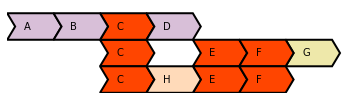

In [418]:
variant_layouting = variants_visualization_factory.apply(ocel_running_example)
visualize_variant(variant_layouting[ocel_running_example.variants[0]])

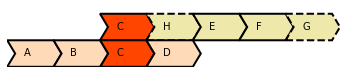

In [419]:
visualize_summarized_variant(summarized_variant_layouting(generic_summarized_variant_3))

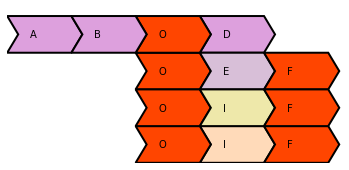

In [420]:
variant_layouting = variants_visualization_factory.apply(ocel_running_example)
visualize_variant(variant_layouting[ocel_running_example.variants[1]])

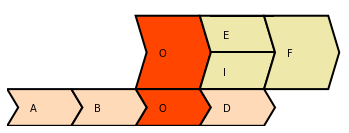

In [421]:
visualize_summarized_variant(summarized_variant_layouting(generic_summarized_variant_2))

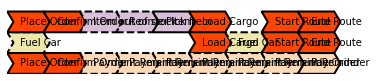

In [422]:
visualize_summarized_variant(summarized_variant_layouting(generic_summarized_variant_1))

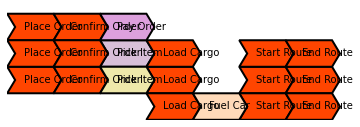

In [338]:
variant_layouting = variants_visualization_factory.apply(ocel_order_process)
visualize_variant(variant_layouting[ocel_order_process.variants[0]])